# Customer Segmentation Clustering
In this noteboook, we use previously cleaned data with Recency, Frequency, Monetary Value, and Tenure to develop customer clusters using a k-means clustering algorithm. This data was collected from Laurie's Books in Oregon City, Oregon and has been anonymized with unique ID numbers. It covers transactions from part of September 2023 through February 2024.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('customers_for_clustering.csv')

Check some samples instead of `.head()` so we get a variety of tenure values.
- `days_since_last` are the days since the last transaction (Recency).
- `transactions` are totals over the five month period (Frequency).
- `total_spending` is Monetary Value.
- `tenure` is Tenure measured as days since their first purchase.

In [3]:
df.sample(5)

,uid,days_since_last,transactions,total_spending,tenure
172,3997857,2.0,10,149.48,141.0
342,16026742,39.0,2,37.61,115.0
483,24010504,88.0,1,23.97,88.0
191,34967461,13.0,3,49.95,139.0
357,20936075,81.0,2,28.99,113.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid              889 non-null    int64  
 1   days_since_last  889 non-null    float64
 2   transactions     889 non-null    int64  
 3   total_spending   889 non-null    float64
 4   tenure           889 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.9 KB


In [5]:
df.describe()

,uid,days_since_last,transactions,total_spending,tenure
count,8.890000e+02,889.000000,889.000000,889.000000,889.000000
mean,4.989060e+07,66.109111,1.769404,40.726130,90.026997
std,2.881307e+07,48.630599,2.148676,57.171503,49.240417
min,7.696000e+03,1.000000,1.000000,1.000000,1.000000
25%,2.416825e+07,22.000000,1.000000,12.000000,42.000000
50%,5.011974e+07,56.000000,1.000000,24.000000,97.000000
75%,7.441599e+07,111.000000,2.000000,48.960000,134.000000
max,9.980022e+07,161.000000,48.000000,726.370000,161.000000


Visualize the distributions to see if transformations are warranted. There is reason to suspect that the `transactions` values may not be able to be adequately transformed or clustered since most of the values are 1.

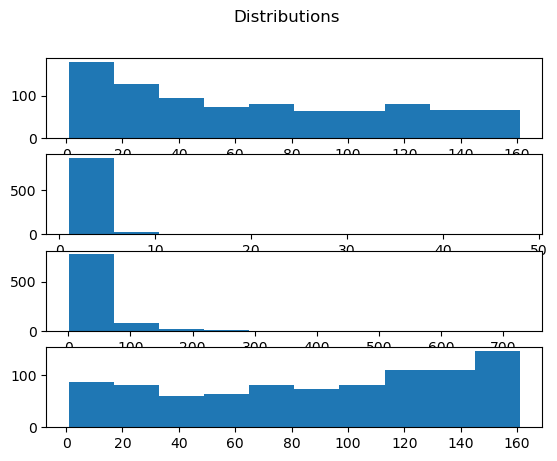

In [6]:
fig, axs = plt.subplots(4)
fig.suptitle('Distributions')
axs[0].hist(df.days_since_last)
axs[1].hist(df.transactions)
axs[2].hist(df.total_spending)
axs[3].hist(df.tenure)
plt.show()

It appears that we should attempt transformations and see what helps. 

In [7]:
df_log = pd.concat([df.uid, 
                    np.power(df.days_since_last, 1./2), 
                    np.log(df.transactions), 
                    np.log(df.total_spending),
                    np.log(df.tenure)], axis=1)
df_log.rename(columns={'days_since_last': 'R', 'transactions': 'F', 'total_spending': 'M', 'tenure': 'T'}, inplace=True)

In [8]:
df_log.describe()

,uid,R,F,M,T
count,8.890000e+02,889.000000,889.000000,889.000000,889.000000
mean,4.989060e+07,7.421832,0.346318,3.210922,4.202861
std,2.881307e+07,3.322339,0.563676,0.963035,0.980531
min,7.696000e+03,1.000000,0.000000,0.000000,0.000000
25%,2.416825e+07,4.690416,0.000000,2.484907,3.737670
50%,5.011974e+07,7.483315,0.000000,3.178054,4.574711
75%,7.441599e+07,10.535654,0.693147,3.891004,4.897840
max,9.980022e+07,12.688578,3.871201,6.588060,5.081404


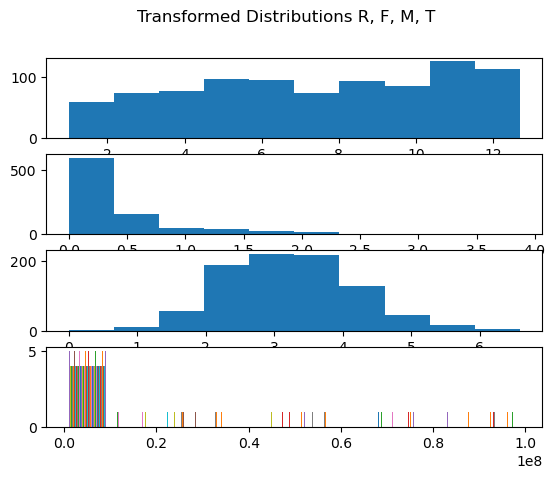

In [9]:
fig, axs = plt.subplots(4)
fig.suptitle('Transformed Distributions R, F, M, T')
axs[0].hist(df_log.R)
axs[1].hist(df_log.F)
axs[2].hist(df_log.M)
axs[3].hist(df_log.T)
plt.show()

Iterating over a few transformation methods, it appears that transformation helped for R and M but not the other two. We will make a new DataFrame that includes the beneficial transformations and run KMeans with and without the unsuccessful transformed data.

In [10]:
df_rfm = pd.concat([df.uid, 
                df_log.R,
                df.transactions, 
                df_log.M,
                df.tenure], axis=1)
df_rfm.rename(columns={'transactions': 'F', 'tenure': 'T'}, inplace=True)

In [11]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   uid     889 non-null    int64  
 1   R       889 non-null    float64
 2   F       889 non-null    int64  
 3   M       889 non-null    float64
 4   T       889 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.9 KB


Our final k-means preprocessing step is to scale our data so it has normalized mean and variance. We'll switch the uid to the index so we don't transform or cluster it and can recover it later. 

In [12]:
# Fit and transform the data without the uid
normalized = StandardScaler().fit_transform(df_rfm.drop('uid', axis=1))

In [13]:
# Create a dataframe with the uid as the index
df_norm = pd.DataFrame(normalized, index=df_rfm.uid, columns=df_rfm.drop('uid',axis=1).columns)

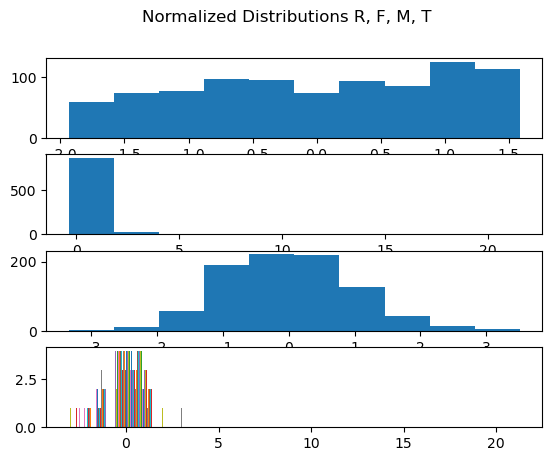

In [14]:
fig, axs = plt.subplots(4)
fig.suptitle('Normalized Distributions R, F, M, T')
axs[0].hist(df_norm.R)
axs[1].hist(df_norm.F)
axs[2].hist(df_norm.M)
axs[3].hist(df_norm.T)
plt.show()

### Run KMeans
Here, we'll start looking for the best number of clusters and features to use. We'll start with R and M that are approximately normally distributed. We'll find the best number of clusters through the elbow method and comparing the silhouette score. 

### Two features

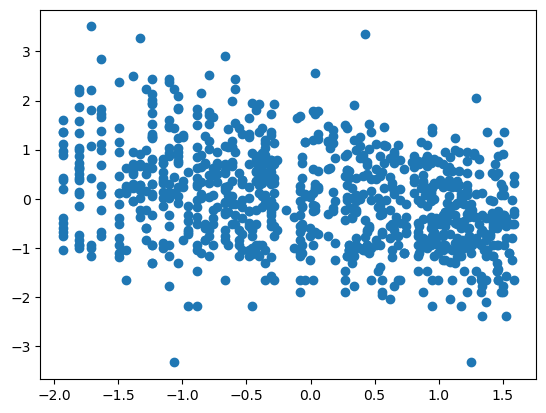

In [15]:
# Create and visualize the DataFrame with two features.
df_2f = df_norm[['R', 'M']]
plt.scatter(df_2f.R, df_2f.M)
plt.show()

In [16]:
sse = {}
sil = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(df_2f)
    sse[k] = kmeans.inertia_
    sil[k] = silhouette_score(df_2f, labels)
    print(f'For {k} clusters, intertia is {round(sse[k],3)}, silhouette score is {round(sil[k],3)}.')

For 2 clusters, intertia is 958.242, silhouette score is 0.408.
For 3 clusters, intertia is 682.522, silhouette score is 0.377.
For 4 clusters, intertia is 485.412, silhouette score is 0.382.
For 5 clusters, intertia is 397.064, silhouette score is 0.376.
For 6 clusters, intertia is 348.412, silhouette score is 0.361.
For 7 clusters, intertia is 296.096, silhouette score is 0.34.
For 8 clusters, intertia is 262.332, silhouette score is 0.347.


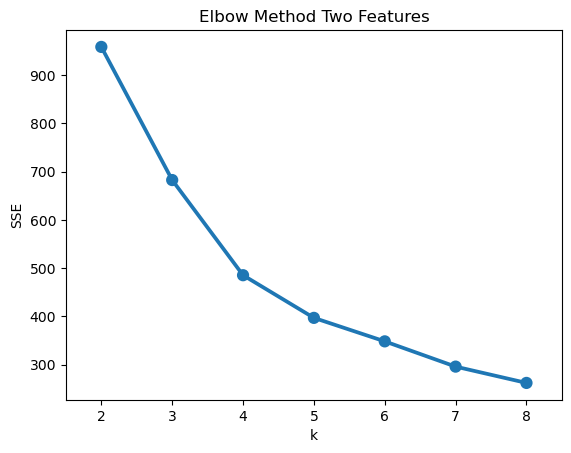

In [17]:
sns.pointplot(x=pd.Series(sse.keys()), y=pd.Series(sse.values()))
plt.title('Elbow Method Two Features')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

From the plot and the silhouette scores, it looks like four is the optimal number of clusters. The silhouette score is higher with two clusters but that gives us less information than four does.

In [18]:
kmeans2 = KMeans(n_clusters=4, n_init='auto', random_state=42)
kmeans2.fit_predict(df_2f)
labels2 = kmeans2.labels_

In [19]:
df_2f_lab = df.assign(cluster=labels2)

In [20]:
table_2f = df_2f_lab.groupby(['cluster']).agg({
    'days_since_last': ['mean', 'std'],
    'transactions': ['mean', 'std'],
    'total_spending': ['mean', 'std'],
    'tenure': ['mean', 'std', 'count']
}).round(1)
table_2f

days_since_last       transactions      total_spending       tenure  \
                   mean   std         mean  std           mean   std   mean   
cluster                                                                       
0                  21.4  16.0          3.6  3.9          101.5  93.5   95.5   
1                 115.5  29.2          1.1  0.3           10.9   4.6  116.9   
2                  25.3  15.6          1.3  0.6           18.8   9.1   42.4   
3                  98.4  29.4          1.4  0.9           43.5  22.2  109.0   

                     
          std count  
cluster              
0        51.8   197  
1        29.7   243  
2        40.3   242  
3        32.3   207

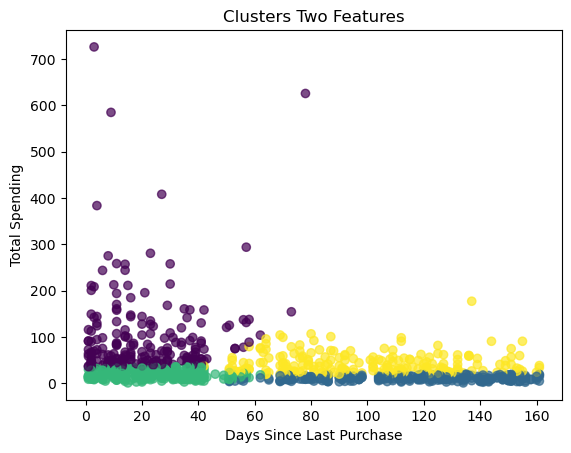

In [21]:
plt.scatter(df_2f_lab.days_since_last, df_2f_lab.total_spending, c=df_2f_lab.cluster, alpha=0.7)
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spending')
plt.title('Clusters Two Features')
plt.show()

### Three Features
The other two features vary from normal a different amount. We'll add one before the other, namely, tenure and then transactions.

In [22]:
# Create and visualize the DataFrame with three features.
df_3f = df_norm[['R', 'M', 'T']]

In [23]:
sse = {}
sil = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(df_3f)
    sse[k] = kmeans.inertia_
    sil[k] = silhouette_score(df_3f, labels)
    print(f'For {k} clusters, intertia is {round(sse[k],3)}, silhouette score is {round(sil[k],3)}.')

For 2 clusters, intertia is 1634.432, silhouette score is 0.355.
For 3 clusters, intertia is 1014.487, silhouette score is 0.413.
For 4 clusters, intertia is 827.944, silhouette score is 0.366.
For 5 clusters, intertia is 687.087, silhouette score is 0.337.
For 6 clusters, intertia is 620.287, silhouette score is 0.333.
For 7 clusters, intertia is 544.392, silhouette score is 0.318.
For 8 clusters, intertia is 468.041, silhouette score is 0.327.


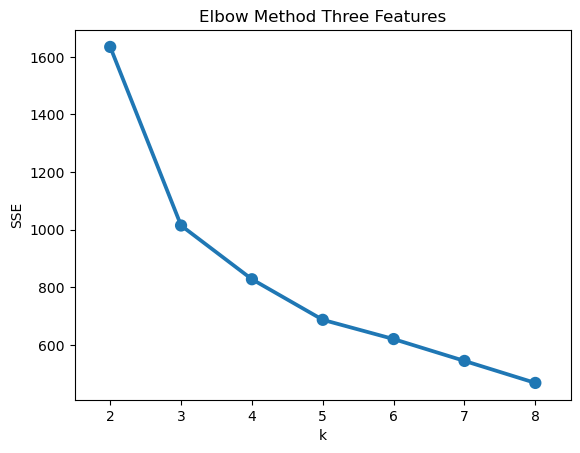

In [24]:
sns.pointplot(x=pd.Series(sse.keys()), y=pd.Series(sse.values()))
plt.title('Elbow Method Three Features')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

The best cluster number here appears to be 3. The silhouette score is higher than two features but the SSE is more than twice as much.

In [25]:
kmeans3 = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans3.fit_predict(df_3f)
labels3 = kmeans3.labels_

In [26]:
df_3f_lab = df.assign(cluster=labels3)

In [27]:
table_3f = df_3f_lab.groupby(['cluster']).agg({
    'days_since_last': ['mean', 'std'],
    'total_spending': ['mean', 'std'],
    'tenure': ['mean', 'std', 'count']
}).round(1)
table_3f

days_since_last       total_spending       tenure            
                   mean   std           mean   std   mean   std count
cluster                                                              
0                  36.1  28.3           98.9  92.1  122.0  28.9   209
1                  25.5  17.5           26.1  19.9   30.3  19.5   294
2                 113.3  28.4           20.4  15.2  118.2  28.0   386

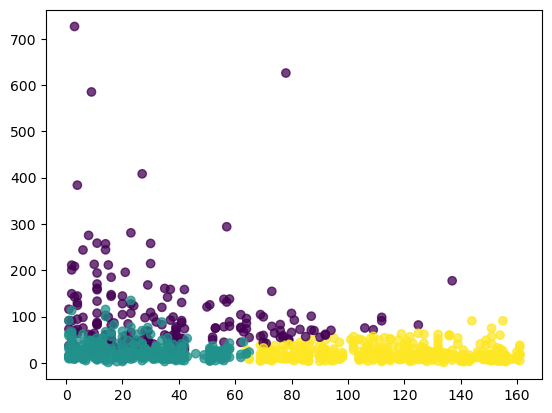

In [28]:
plt.scatter(df_3f_lab.days_since_last, df_3f_lab.total_spending, c=df_3f_lab.cluster, alpha=0.75)
plt.show()

### Four Features

In [29]:
# Create and visualize the DataFrame with three features.
df_4f = df_norm[['R', 'F', 'M', 'T']]

In [30]:
sse = {}
sil = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(df_4f)
    sse[k] = kmeans.inertia_
    sil[k] = silhouette_score(df_4f, labels)
    print(f'For {k} clusters, intertia is {round(sse[k],3)}, silhouette score is {round(sil[k],3)}.')

For 2 clusters, intertia is 2480.572, silhouette score is 0.333.
For 3 clusters, intertia is 1665.934, silhouette score is 0.413.
For 4 clusters, intertia is 1490.043, silhouette score is 0.31.
For 5 clusters, intertia is 1265.168, silhouette score is 0.319.
For 6 clusters, intertia is 901.086, silhouette score is 0.323.
For 7 clusters, intertia is 754.466, silhouette score is 0.327.
For 8 clusters, intertia is 675.794, silhouette score is 0.304.


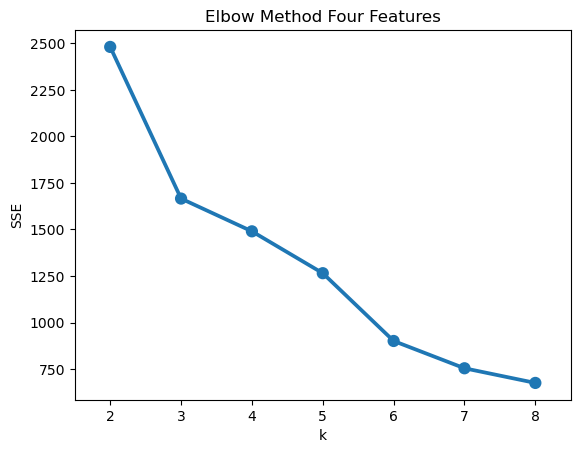

In [31]:
sns.pointplot(x=pd.Series(sse.keys()), y=pd.Series(sse.values()))
plt.title('Elbow Method Four Features')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

Again, here we see three clusters performing the best. The silhouette score is comparable to the three feature model but the SSE are even higher here. 

In [32]:
kmeans4 = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans4.fit_predict(df_4f)
labels4 = kmeans4.labels_

In [33]:
df_4f_lab = df.assign(cluster=labels4)

In [34]:
table_4f = df_4f_lab.groupby(['cluster']).agg({
    'days_since_last': ['mean', 'std'],
    'transactions': ['mean', 'std'],
    'total_spending': ['mean', 'std'],
    'tenure': ['mean', 'std', 'count']
}).round(1)
table_4f

days_since_last       transactions      total_spending       tenure  \
                   mean   std         mean  std           mean   std   mean   
cluster                                                                       
0                  30.7  25.0          4.1  3.9          103.9  96.9  126.5   
1                  26.0  17.8          1.2  0.5           26.8  21.1   31.2   
2                 111.3  29.4          1.1  0.4           22.8  19.3  116.8   

                     
          std count  
cluster              
0        27.6   182  
1        20.4   299  
2        28.0   408

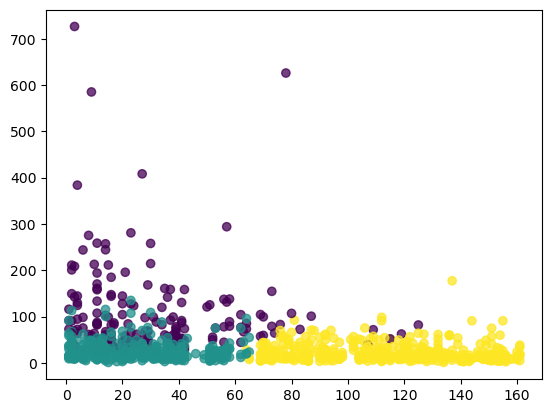

In [35]:
plt.scatter(df_4f_lab.days_since_last, df_4f_lab.total_spending, 
            c=df_4f_lab.cluster, alpha=0.75)
plt.show()

### Best Model and Summary

Our best model appears to be the one using two features. The additional, non-normalized features introduced more noise. Here is the plot for the best fit with four clusters on two features again.

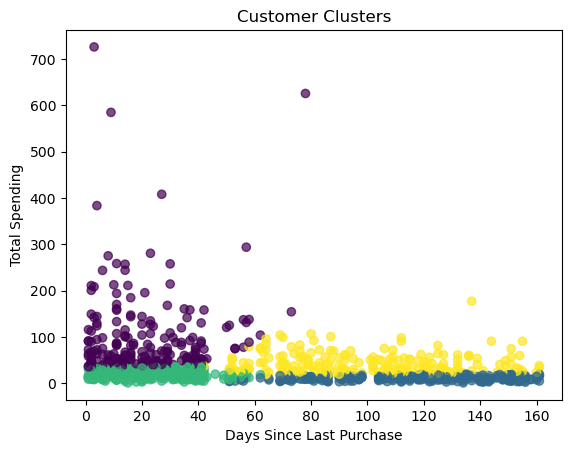

In [36]:
plt.scatter(df_2f_lab.days_since_last, df_2f_lab.total_spending, c=df_2f_lab.cluster, alpha=0.7)
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spending')
plt.title('Customer Clusters')
plt.savefig('customer_clusters.png')
plt.show()

The purple cluster is the most frequent, highest grossing purchasing group. The yellow are also higher purchasing but may not have visited the store as recently. The green and blue groups visit in varying frequency and may only buy a few low-priced books at a time. At this point, the cluster with the highest spending is worth deanonymizing and further investigating their buying habits in terms of genres and authors and sharing the results with the store staff.

In [37]:
df_2f_lab[['uid', 'cluster']].to_csv('customer_clusters.csv', index=False)